In [1]:
# 주성분 분석 PCA : principal component analysis은 금융공학에서 인기있는 도구이다.
# 주성분 분석은 직교 변환(orthogonal transformation)을 사용하여 
# 상관관계를 가지는 관측값 변수들의 집합을 주성분(principal component)이라고 하는 선형 상관관계를 가지지 않는 변수,
# 즉 주성분의 집합으로 바꾸는 통계적 절차다. 주성분의 수는 원래 변수의 수와 같거나 적다.

# 변환은 첫 번째 주성분이(자료의 변동성을 가장 많이 설명하도록) 가장 큰 분산을 가지고
# 그 다음 성분이 이전의 주성분과 직교한다는 제약 조건 하에 가장 큰 분산을 가지도록 정의한다.

# 예를 들어 30개의 주식으로 구성된 독일 DAX 지수와 같은 주가지수를 생각해보자
# 통계적 관점에서 주가지수 하나의 움직임을 설명하기 위해 30개의 상관관계를 가지는 요인을 모두 사용하는 것은 일반적으로 아주 어려운 일이다.
# 이 때 필요한 게 주성분 분석이다. 주성분 분석을 사용하면 주가지수의 움직임을 잘 설명할 수 있으면서, 
# 서로 상관관계가 없는 몇 개의 성분을 유도할 수 있다. 
# 이는 몇 가지 주식을 선택하고 (포트폴리오처럼) 선형적으로 조합하는 것과 마찬가지이다.
# 다만 상관관계가 있는 30개의 주가지수 구성 요소를 모두 사용하는 것이 아니라 5개 혹은 3개, 아니면 하나의 주성분만을 사용할 수 있다.

# 여기서는 독일 DAX 지수와 이를 구성하는 주식의 자료를 구한 다음 주성분 분석을 통해 pca_index라고 부르게 되는 주성분을 도출한다.
# 우선 몇 가지 라이브러리를 임포트하고, scikit-learn 머신 러닝 라이브러리의 KernelPCA 함수를 사용한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()

from sklearn.decomposition import KernelPCA

# 독일 DAX 지수와 이 지수를 구성하는 30개 주식의 종목코드
symbols = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE',
           'BMW.DE', 'CBK.DE', 'CON.DE', 'DAI.DE', 'DB1.DE',
           'DBK.DE', 'DPW.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE',
           'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE',
           'LIN.DE', 'LXS.DE', 'MRK.DE', 'MUV2.DE', 'RWE.DE',
           'SAP.DE', 'SDF.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE',
           '^GDAXI']

In [7]:
%%time

# 수정 종가 자료를 가져오자
data = pd.DataFrame()
for sym in symbols:
    # only retrieves data from Jan 2016 on
    data[sym] = pdr.get_data_yahoo(sym, start='2016-1-1')['Adj Close']
data = data.dropna()
print('')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
# 지수 자료는 별도로 사용해야 하므로 분리했다.
dax = pd.DataFrame(data.pop('^GDAXI'))

# 이제 data에는 30개의 DAX 주식 값이 들어가 있다.
print(data[data.columns[:6]].head(10))

ADS.DE      ALV.DE     BAS.DE    BAYN.DE     BEI.DE     BMW.DE
Date                                                                         
2016-01-04  80.298233  116.258247  50.431751  92.232994  78.003090  73.104820
2016-01-05  80.023048  116.630875  50.148174  92.399269  78.849281  72.764061
2016-01-06  79.096611  117.003494  49.312374  91.069992  78.339645  70.354965
2016-01-07  77.867455  114.581436  48.110905  88.744843  76.426102  67.708130
2016-01-08  76.546570  113.128227  47.521362  86.293945  76.233788  66.123215
2016-01-11  78.206848  113.575371  47.200481  85.380760  75.560684  65.885468
2016-01-12  79.151634  114.991325  47.991505  86.543762  77.839615  67.240585
2016-01-13  78.647141  115.177643  47.969112  86.667831  78.330025  65.687363
2016-01-14  77.702347  113.202744  47.700466  85.422112  76.503021  63.484306
2016-01-15  77.060249  111.227837  46.125874  83.553566  75.445297  61.828049


In [9]:
# 주성분 분석을 적용해보자
# 주성분 분석은 정규화된 자료를 다루므로 보조 정규화 함수를 사용하자
scale_function = lambda x: (x - x.mean()) / x.std()

data_scaled = data.apply(scale_function)
dax_scaled = dax.apply(scale_function)
# 일단 주성분의 수에 제한을 두지 않고 복수의 주성분을 가지는 주성분 분석을 고려하자
pca = KernelPCA().fit(data_scaled)
# 여기서는 통계적으로 더 다루기 좋은 수익률이 아닌 절대 주가를 다룬다.
# 그 이유는 가격 자료가 더 직관적이고 그래프를 해석하기도 쉽기 때문이다.
# 실무에서 응용할 때는 수익률 자료를 사용하게 된다.

# 각 성분의 중요도 혹은 설명 능력은 해당 성분의 고유 값(eigenvalue)로 결정된다. 고유 값은 KernelPCA 객체의 속성에서 볼 수 있다.
print(len(pca.lambdas_))


612


In [5]:
# 분석 결과 성분의 수가 너무 많으므로 10개의 성분만 살펴보자
print(pca.lambdas_[:10].round())


[18298. 10901.  2046.  1192.   579.   469.   373.   333.   267.   210.]


In [6]:
# 우리가 관심을 가지는 것은 각 성분의 상대적인 중요도이므로 정규화를 한다.
# 정규화에는 아까 정의한 보조 함수를 사용한다.
get_we = lambda x: x / x.sum()
print(get_we(pca.lambdas_)[:10])

# 6개의 주성분만으로 변동치의 95%를 설명할 수 있다.
print(get_we(pca.lambdas_)[:6].sum())


[0.51385077 0.30612953 0.05745551 0.03346039 0.01626234 0.01318276
 0.01046911 0.00933957 0.0074976  0.00588444]
0.9403413107934228


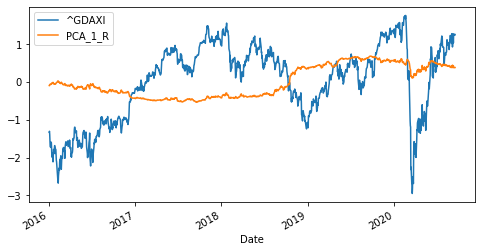

In [15]:
# 주성분 지수 구성

# 주성분 분석을 사용한 주성분 지수를 구성하여 원래의 지수와 비교한다. 첫번째로 하나의 성분만을 가지는 주성분 지수를 만든다

pca_1_rbf = KernelPCA(n_components=1, kernel='rbf', gamma=0.04)

dax_scaled['PCA_1_R'] = pca_1_rbf.fit_transform(data_scaled)

# 정규화 결과를 시각화해 보자
# 독일 DAX지수와 단일 성분으로 된 주성분 분석 지수를 나타낸다.
%matplotlib inline
dax_scaled.plot(figsize=(8, 4))
# tag: pca_1
# title: German DAX index and PCA index with 1 component

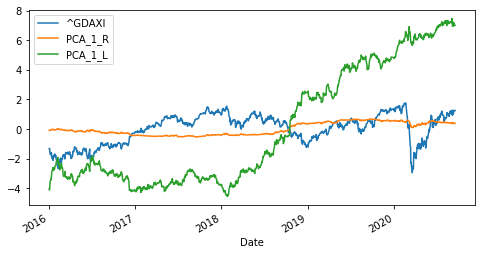

In [27]:
# 같은 조건에 선형으로 해보자
pca_1_linear = KernelPCA(n_components=1, kernel='linear')

dax_scaled['PCA_1_L'] = pca_1_linear.fit_transform(data_scaled)

# 정규화 결과를 시각화해 보자
# 독일 DAX지수와 단일 성분으로 된 주성분 분석 지수를 나타낸다.
%matplotlib inline
dax_scaled.plot(figsize=(8, 4))
# tag: pca_2
# title: German DAX index and PCA index with 1 component

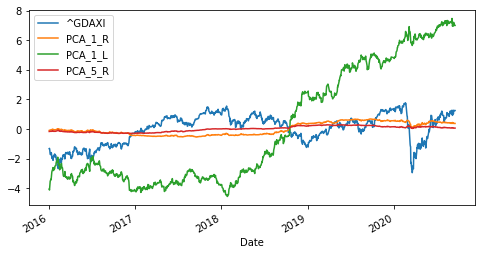

In [41]:
# 결과가 그다지 좋지 않다. 주성분의 개수를 증가시켜 결과를 향상시켜 보자
# 이를 위해서는 단일 성분인 경우의 가중 평균을 계산해야 한다.
pca_5_rbf = KernelPCA(n_components=5, kernel='rbf', gamma=0.04)
pca_components = pca_5_rbf.fit_transform(data_scaled)
weights = get_we(pca_5_rbf.lambdas_)
dax_scaled['PCA_5_R'] = np.dot(pca_components, weights)

# 결과 시각화. 조금 결과가 나아졌다.
%matplotlib inline
dax_scaled.plot(figsize=(8, 4))
# tag: pca_3
# title: German DAX index and PCA indices with 1 and 5 components

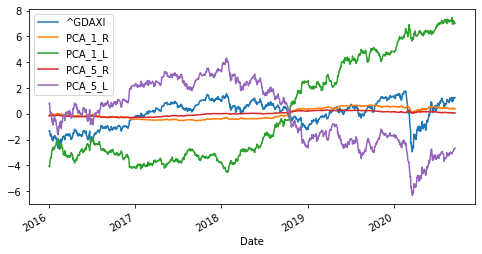

In [56]:
# 커널을 선형으로 바꿔보자
# 이를 위해서는 단일 성분인 경우의 가중 평균을 계산해야 한다.
pca_5_linear = KernelPCA(n_components=5, kernel='linear')
pca_components = pca_5_linear.fit_transform(data_scaled)
weights = get_we(pca_5_linear.lambdas_)
dax_scaled['PCA_5_L'] = np.dot(pca_components, weights)

# 결과 시각화. 큰 차이 없다.
%matplotlib inline
dax_scaled.plot(figsize=(8, 4))
# tag: pca_4
# title: German DAX index and PCA indices with 1 and 5 components

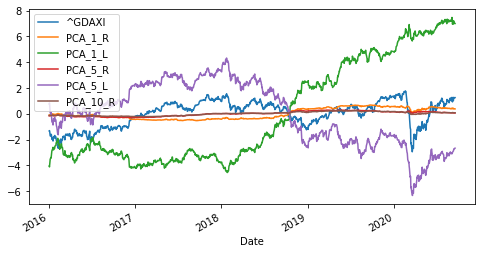

In [63]:
# 주성분 갯수를 10개로 해보자
pca_10_rbf = KernelPCA(n_components=10, kernel='rbf', gamma=0.04)
pca_components = pca_10_rbf.fit_transform(data_scaled)
weights = get_we(pca_10_rbf.lambdas_)
dax_scaled['PCA_10_R'] = np.dot(pca_components, weights)

# 결과 시각화.
%matplotlib inline
dax_scaled.plot(figsize=(8, 4))
# tag: pca_5
# title: German DAX index and PCA indices with 1 and 10 components

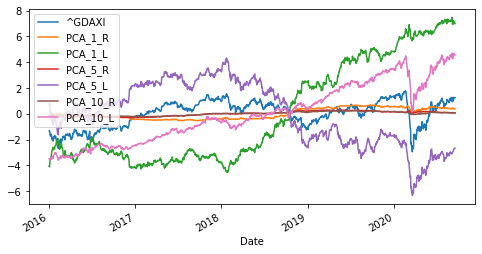

In [66]:
# 주성분 갯수를 10개로 하고 커널을 선형으로 바꿔보자
pca_10_linear = KernelPCA(n_components=10, kernel='linear')
pca_components = pca_10_linear.fit_transform(data_scaled)
weights = get_we(pca_10_linear.lambdas_)
dax_scaled['PCA_10_L'] = np.dot(pca_components, weights)

# 결과 시각화.
%matplotlib inline
dax_scaled.plot(figsize=(8, 4))
# tag: pca_6
# title: German DAX index and PCA indices with 1 and 10 components

[735967. 735968. 735969. 735970. 735971. 735974. 735975. 735976. 735977.
 735978.]


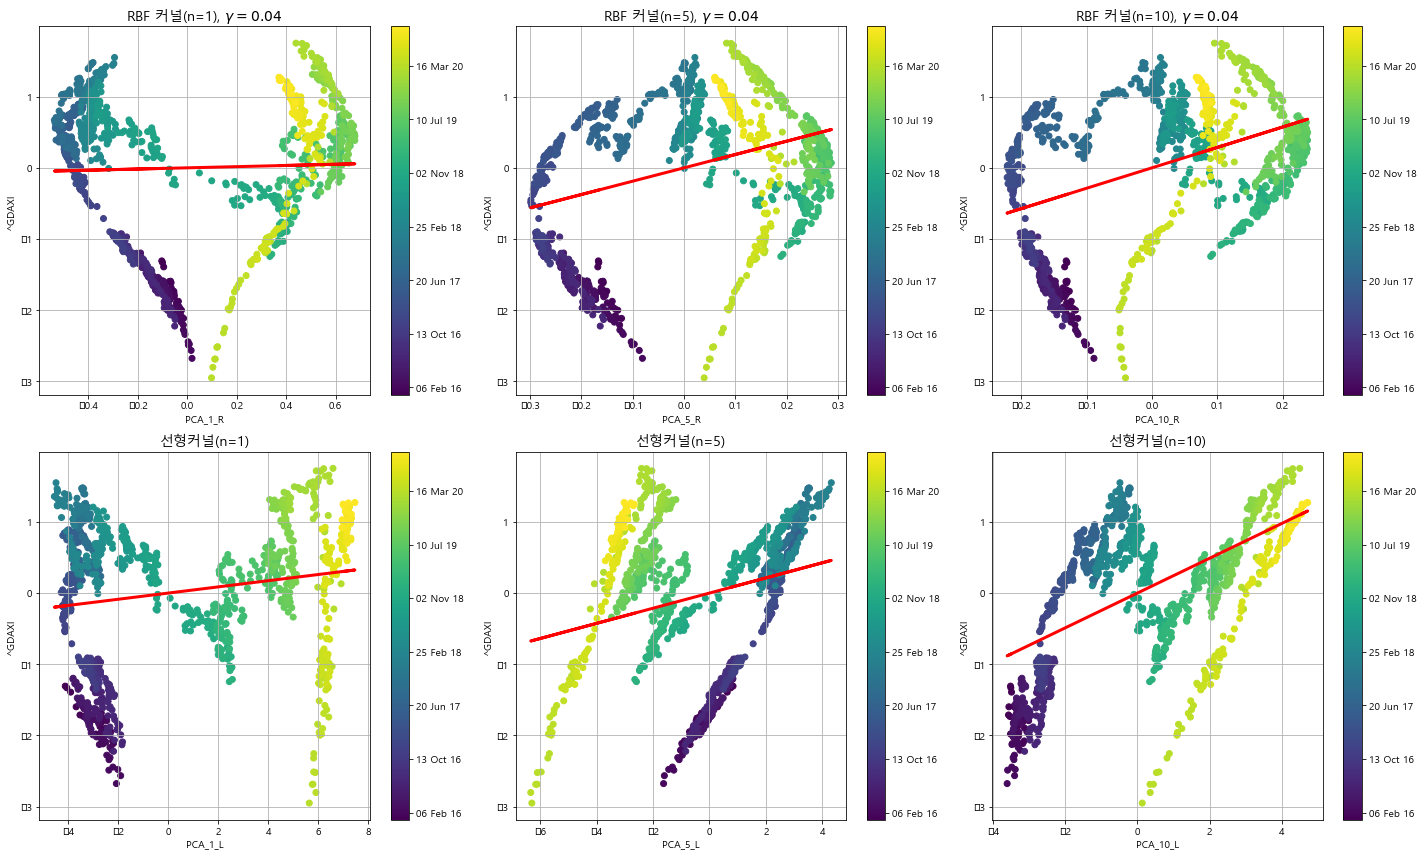

In [70]:
# 지금까지의 결과를 분석하는 데 있어 DAX지수와 주성분 지수 사이의 관계를 지금까지와는 달리 날자 정보를 추가한 스캐터 플롯을 통해 살펴보자
# 우선 DataFrame 객체의 DatetimeIndex를 matplotlib에 호환되는 형식으로 변환한다.
import matplotlib as mpl

mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())
print(mpl_dates[:10])

# font를 지정하면 한글이 깨지지 않음
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname=r"c:\\Windows\\Fonts\\malgun.ttf").get_name()
rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False      # 축 눈금 마이너스 깨지는 문제 해결

# 이 새로운 날짜 리스트는 날짜에 따라 각각의 자료를 나타내는 점의 색이 달라지는 스캐터 플롯을 작성하는데 사용된다.
# 주성분 분석 지수가 DAX지수를 정확히 복제하였다면 일직선 상에 모든 점들이 존재하고 이 위로 회귀선이 있어야 한다.
# 구조적 변동 모형을 사용하면 이 회귀분석 결과를 완벽하지는 않더라도 어느 정도 향상시킬 수 있다.

plt.figure(figsize=(20, 12))

for subplot, pca, title in ((231, "PCA_1_R", "RBF 커널(n=1), $\gamma=0.04$"), (234, "PCA_1_L","선형커널(n=1)"), (232, "PCA_5_R", "RBF 커널(n=5), $\gamma=0.04$"), (235, "PCA_5_L", "선형커널(n=5)"), (233, "PCA_10_R", "RBF 커널(n=10), $\gamma=0.04$"), (236, "PCA_10_L", "선형커널(n=10)")):
    X_reduced = dax_scaled[pca]
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)

    plt.scatter(X_reduced, dax_scaled['^GDAXI'], c=mpl_dates)

    lin_reg = np.polyval(np.polyfit(X_reduced, dax_scaled['^GDAXI'], 1),
                                X_reduced)
    plt.plot(X_reduced, lin_reg, 'r', lw=3)

    plt.grid(True)
    plt.xlabel(pca)
    plt.ylabel('^GDAXI')
    plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

plt.tight_layout()
plt.show()



In [71]:
# RBF 비선형 매핑 커널은 해석에 큰 도움이 안되고 선형 커널 결과물로 더 해석을 진행해보자
# 그림을 보면 2018년 중반쯤 어떤 종류의 구조적 변동이 존재하였음을 알 수 있다.
# 주성분 분석 지수가 DAX지수를 정확히 복제하였다면 일직선 상에 모든 점들이 존재하고 이 위로 회귀선이 있어야 한다.
# 구조적 변동 모형을 사용하면 이 회귀분석 결과를 완벽하지는 않더라도 어느 정도 향상시킬 수 있다.
# 그러기 위해 전체 시간 구간을 두 개의 구간으로 나눈다. 그리고 초기 구간과 후기 구간에 대해 각각 회귀분석을 한다.

cut_date = '2018-7-1'
early_pca_1 = dax_scaled[dax_scaled.index < cut_date]['PCA_1_L']
early_reg_1 = np.polyval(np.polyfit(early_pca_1,
                dax_scaled['^GDAXI'][dax_scaled.index < cut_date], 1),
                early_pca_1)

early_pca_5 = dax_scaled[dax_scaled.index < cut_date]['PCA_5_L']
early_reg_5 = np.polyval(np.polyfit(early_pca_5,
                dax_scaled['^GDAXI'][dax_scaled.index < cut_date], 1),
                early_pca_5)

early_pca_10 = dax_scaled[dax_scaled.index < cut_date]['PCA_10_L']
early_reg_10 = np.polyval(np.polyfit(early_pca_10,
                dax_scaled['^GDAXI'][dax_scaled.index < cut_date], 1),
                early_pca_10)

late_pca_1 = dax_scaled[dax_scaled.index >= cut_date]['PCA_1_L']
late_reg_1 = np.polyval(np.polyfit(late_pca_1,
                dax_scaled['^GDAXI'][dax_scaled.index >= cut_date], 1),
                late_pca_1)

late_pca_5 = dax_scaled[dax_scaled.index >= cut_date]['PCA_5_L']
late_reg_5 = np.polyval(np.polyfit(late_pca_5,
                dax_scaled['^GDAXI'][dax_scaled.index >= cut_date], 1),
                late_pca_5)

late_pca_10 = dax_scaled[dax_scaled.index >= cut_date]['PCA_10_L']
late_reg_10 = np.polyval(np.polyfit(late_pca_10,
                dax_scaled['^GDAXI'][dax_scaled.index >= cut_date], 1),
                late_pca_10)

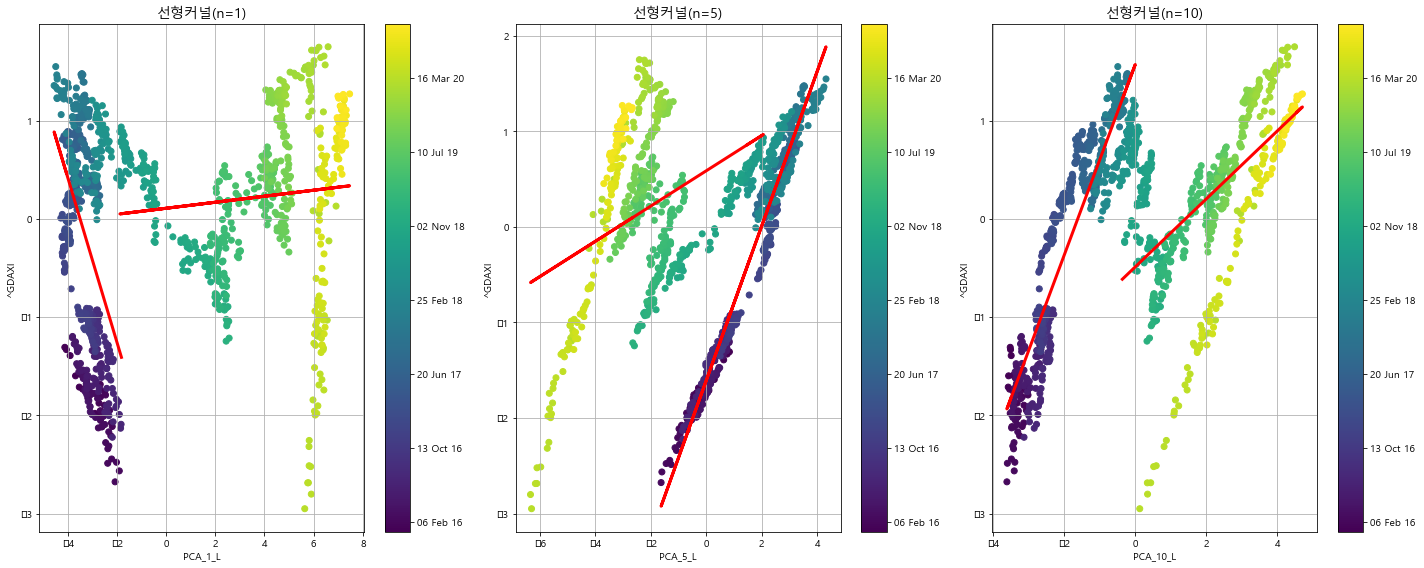

In [73]:
# 새 회귀선 시각화를 해보자
plt.figure(figsize=(20, 8))

for subplot, pca, title in ((131, "PCA_1_L","선형커널(n=1)"), (132, "PCA_5_L", "선형커널(n=5)"), (133, "PCA_10_L", "선형커널(n=10)")):
    X_reduced = dax_scaled[pca]
    
    if pca == "PCA_1_L":

        early_pca = early_pca_1
        early_reg = early_reg_1

        late_pca = late_pca_1
        late_reg = late_reg_1
    
    elif pca == "PCA_5_L":

        early_pca = early_pca_5
        early_reg = early_reg_5

        late_pca = late_pca_5
        late_reg = late_reg_5
    
    else:
        early_pca = early_pca_10
        early_reg = early_reg_10

        late_pca = late_pca_10
        late_reg = late_reg_10

    plt.subplot(subplot)
    plt.title(title, fontsize=14)

    plt.scatter(X_reduced, dax_scaled['^GDAXI'], c=mpl_dates)

    plt.plot(early_pca, early_reg, 'r', lw=3)
    plt.plot(late_pca, late_reg, 'r', lw=3)

    plt.grid(True)
    plt.xlabel(pca)
    plt.ylabel('^GDAXI')
    plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

plt.tight_layout()
plt.show()

# 새 회귀선 결과를 보면 구간 이전과 이후에 대해 회귀분석 설명력이 높아졌음을 알 수 있다.
# 이런 경험적인 방식은 베이즈 통계를 통해 더 정확하게 다룰 수 있다.
# 그리고 여기서는 2구간으로 나눴지만 3구간으로 나누면 좀 더 좋은 분석이 될 것 같다.

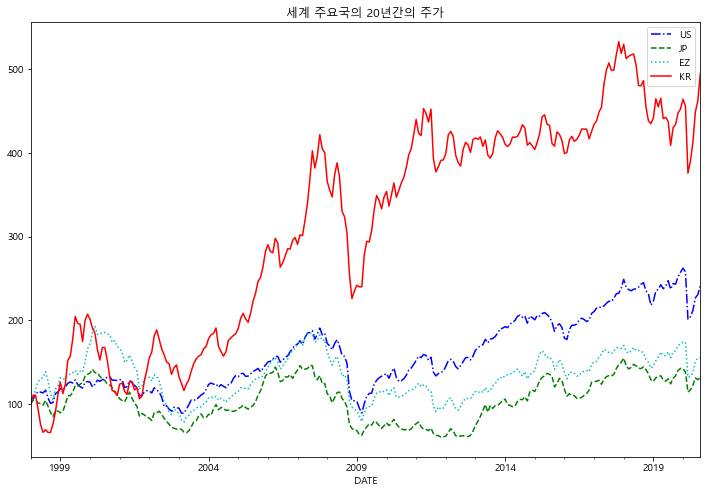

In [7]:
# 이번에는 다른 경우를 가져와 보자

# PCA는 다양한 분야에서 사용된다. 이번에는 금융분야에서 어떻게 쓰이는지 알아보자. 우선 미국(US), 일본(JP), 유럽(EZ), 한국(KR)의 과거 20년간 주가를 살펴보자.

import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# font를 지정하면 한글이 깨지지 않음
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname=r"c:\\Windows\\Fonts\\malgun.ttf").get_name()
rc('font', family=font_name)

symbols = [
    "SPASTT01USM661N", # US: 미국
    "SPASTT01JPM661N", # JP: 일본
    "SPASTT01EZM661N", # EZ: 유럽
    "SPASTT01KRM661N", # KR: 한국
]


data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='fred', 
                               start=datetime.datetime(1998, 1, 1),
                               end=datetime.datetime(2020, 8, 31))[sym]
data.columns = ["US", "JP", "EZ", "KR"]

# 시작시점의 주가가 100이 되도록 크기를 조정
data = data / data.iloc[0] * 100

styles = ["b-.", "g--", "c:", "r-"]
data.plot(style=styles, figsize = (12,8))
plt.title("세계 주요국의 20년간의 주가")
plt.show()


In [8]:
# 이 데이터로부터 연간 주식수익률 데이터를 구하면 다음처럼  20×4  크기의 특징행렬을 구할 수 있다.
df = ((data.pct_change() + 1).resample("A").prod() - 1).T * 100
print(df.iloc[:, :5])

DATE  1998-12-31  1999-12-31  2000-12-31  2001-12-31  2002-12-31
US     14.249290   10.800392    1.094171   -9.638213  -17.680773
JP     -8.567915   47.802619  -18.365577  -23.827406  -16.923968
EZ     21.308040   36.872314    1.375330  -21.857080  -30.647772
KR     10.411582   87.623876  -46.975114   27.644005    4.448180


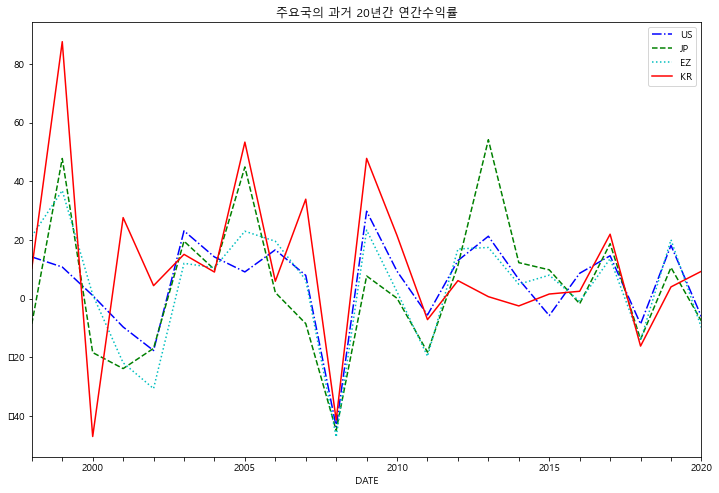

In [9]:
# 연간 주식수익률 데이터를 그래프로 나타내면 다음과 같다. 
# 붓꽃의 경우보다 (2차원에서 20차원으로) 차원은 증가했지만 각 표본이 가지는 측정 데이터 벡터의 모양(비율)이 비슷하다는 것을 알 수 있다. 
# 붓꽃이 측정 데이터의 값을 결정하는 "크기"라는 잠재변수를 가지고 있는 것처럼 
# 각 나라의 수익률은 "경제적 요인"이라고 하는 공통된 잠재변수에 의해서 결정되기 때문이다.

df.T.plot(style=styles, figsize = (12,8))
plt.title("주요국의 과거 20년간 연간수익률")
plt.xticks(df.columns)
plt.show()

[[-34.01176429]
 [-20.59324909]
 [-28.23511386]
 [ 82.84012724]]
[  9.35024903  45.7748003  -15.71779759  -6.91967355 -15.20108361
  17.48765584  10.95568389  32.60609686  11.08048721   9.94632162
 -44.28095456  27.19782058   8.32897696 -12.63319273  11.86532327
  23.41445161   5.34108071   3.42888451   2.14468408  17.2613721
 -13.21742621  13.2326573   -3.57249097]
23
[-0.0051231   0.52658187 -0.38842376  0.40318489  0.2363166  -0.03020699
 -0.02529677  0.27458213 -0.07253381  0.27424066  0.03443453  0.23039915
  0.15102451  0.05700621 -0.06970156 -0.24631268 -0.08884373 -0.01101754
 -0.00260874  0.0596837  -0.03867968 -0.11591331  0.15368941]


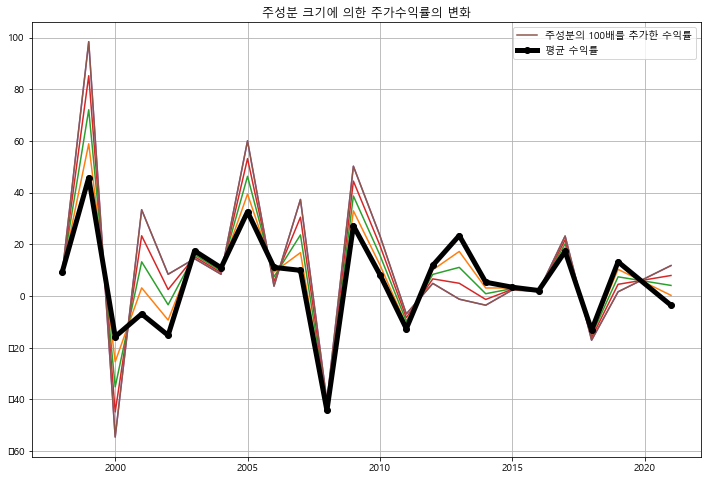

In [18]:
# PCA 분석을 통해 모든 나라의 주가 움직임 기저에 깔려있는 성분을 살펴보자.
from sklearn.decomposition import PCA
import numpy as np

pca2 = PCA(n_components=1)
w = pca2.fit_transform(df)
print(w)

# 일단 세계주가의 공통요인은 평균값으로 구할 수 있다.
m = pca2.mean_
print(m)
print(len(m))

# 그리고 나라별로 주가를 다르게 하는 요인은 주성분으로 구할 수 있다.
p1 = pca2.components_[0]
print(p1)

# 이 두 가지 성분을 차트로 나타내보자. 평균주가로부터 주성분이 더해질수록 어떻게 주가의 형태가 바뀌는지 살펴보면 다음과 같다. 
# 굵은 선으로 표시된 주가가 평균 주가이고 나머지 주가는 주성분이 점점 많이 추가됨에 따라 어떤 주가 형태로 변하는지를 표시한 것이다.
# 여기에서는 주성분의 모습을 잘 보기 위해 주성분을 과장하여 추가하였다.

plt.figure(figsize=(12, 8))
xrange = np.linspace(1998, 2021, 23, dtype=int)
for i in np.linspace(0, 100, 5):
    plt.plot(xrange, pca2.mean_ + p1 * i)
plt.plot(xrange, pca2.mean_ + p1 * 100, label="주성분의 100배를 추가한 수익률")
plt.plot(xrange, pca2.mean_, "ko-", lw=5, label="평균 수익률")
plt.title("주성분 크기에 의한 주가수익률의 변화")
plt.legend()
plt.grid(True)
plt.show()


주성분 비중
US -34.011764
JP -20.593249
EZ -28.235114
KR  82.840127


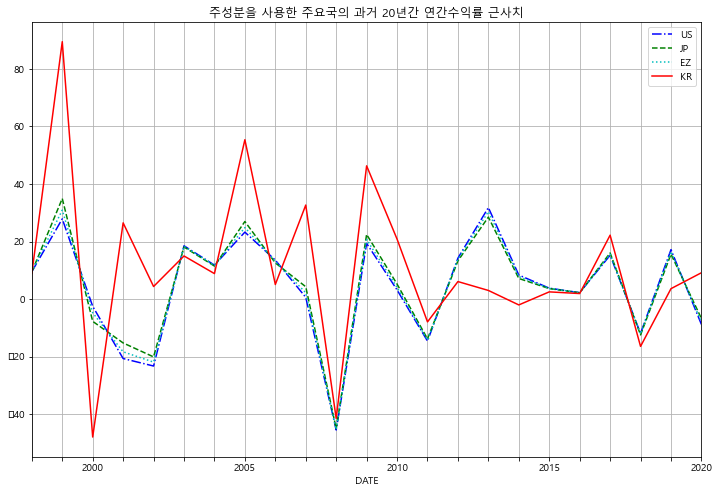

In [20]:
# 이 주성분이 가지는 의미를 살펴보기 위해 각 나라의 주성분 비중을 구한다.

df_w = pd.DataFrame(w)
df_w.index = df.index
df_w.columns = ["주성분 비중"]
print(df_w)

# 한국은 주성분의 비중이 80이 넘고 나머지 국가들은 모두 주성분의 성분이 음수임을 알 수 있다. 
# 또한 주성분을 이용하여 구한 근사 주가를 표시하면 다음과 같다.

df_i = pd.DataFrame(pca2.inverse_transform(w))
df_i.index = df.index
df_i.columns = df.columns
df_i.iloc[:, -10:]
df_i.T.plot(style=styles, figsize=(12,8))
plt.title("주성분을 사용한 주요국의 과거 20년간 연간수익률 근사치")
plt.xticks(df.columns)
plt.grid(True)
plt.show()

# 이 결과로부터 우리가 구한 주성분은 '미국, 일본, 유럽'이라는 데이터로부터 '한국'이라는 데이터로 변화시키는 요인, 
# 즉 중진국 요인이라 부를 수 있는 성분이라는 것을 명확하게 알 수 있다.


